In [2]:
### IMPORT PACKAGES & METHODS ###

# if you need to install 'rijksdriehoek' uncomment line below
#!pip install rijksdriehoek

import datetime
from datetime import date
import requests
import pandas as pd
from bs4 import BeautifulSoup as bs
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point, Polygon
from sklearn.cluster import DBSCAN
from scipy.stats import pearsonr
from math import radians, sqrt, sin, cos, asin
from tqdm import tqdm
from rijksdriehoek import rijksdriehoek
import folium
from folium import plugins

# create method to calculate distance in meters between two points
def distance(point1, point2) :
    # convert points to longitude and latitude
    lon1 = point1.x
    lat1 = point1.y
    lon2 = point2.x
    lat2 = point2.y
    # convert degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
	# calculate difference between latitudes and longitudes
    latdiff = lat2 - lat1 
    londiff = lon2 - lon1
    # haversine formula
    haversine = 2 * asin(sqrt((sin(latdiff/2)**2 + cos(lat1) * cos(lat2) * sin(londiff/2)**2))) 
    # earth radius in km
    radius = 6371
	# distance in meters
    distance = haversine * radius * 1000
    return distance

# disable 'A value is trying to be set on a copy of a slice from a DataFrame' error
pd.options.mode.chained_assignment = None

In [ ]:
### SCRAPE FLICKR DATA ###

# create empty lists to temporarily keep scraped data
idlist = []
ownerlist = []
datetakenlist = []
dateuploadlist = []
latitudelist = []
longitudelist = []
viewslist = []
titlelist = []
tagslist = []
urllist = []

# scrape 2004 (start of Flickr) to last year
yearslist = list(range(datetime.date(2004, 1, 1).year, date.today().year))

for year in tqdm(yearslist) :
    startdate = datetime.date(year, 1, 1)
    enddate = datetime.date(year, 12, 31)
    numberdays = enddate - startdate
    dayslist = list(range(1, numberdays.days + 1))

    for days in dayslist :
        url = 'https://www.flickr.com/services/rest/?method=flickr.photos.search&api_key=219406af910aec2cf37fce88e22e92e1&min_upload_date=' + str(startdate) + '+00%3A00%3A00&max_upload_date=' + str(startdate) + '+23%3A59%3A59&bbox=4.728%2C+52.278%2C+5.108%2C+52.430&accuracy=16&content_type=1&has_geo=1&extras=date_taken%2C+date_upload%2C+geo%2C+views%2C+tags+%2Curl_m&format=rest'
        response = requests.get(url)
        soup = bs(response.content, 'html.parser')
        for tag in soup.find_all('photo') :
            idlist.append(tag.get('id'))
            ownerlist.append(tag.get('owner'))
            datetakenlist.append(tag.get('datetaken'))
            dateuploadlist.append(tag.get('dateupload'))
            latitudelist.append(tag.get('latitude'))
            longitudelist.append(tag.get('longitude'))
            viewslist.append(tag.get('views'))
            titlelist.append(tag.get('title'))
            tagslist.append(tag.get('tags'))
            urllist.append(tag.get('url_m'))
        startdate += datetime.timedelta(days = 1)

    retrievedinfo = {'id': idlist, 'owner': ownerlist, 'datetaken': datetakenlist, 'dateupload': dateuploadlist, 'latitude': latitudelist, 'longitude': longitudelist, 'views': viewslist, 'title': titlelist, 'tags': tagslist, 'url': urllist}
    retrievedlist = pd.DataFrame(data = retrievedinfo)
    retrievedlist.to_csv('data/flickr-rawdata.csv', index = False)
    print(str(year) + ' done! Next year processing...')
    
# scrape current year
startdate = datetime.date(date.today().year, 1, 1)
enddate = date.today()
numberdays = enddate - startdate
dayslist = list(range(1, numberdays.days + 1))

for days in tqdm(dayslist) :
    url = 'https://www.flickr.com/services/rest/?method=flickr.photos.search&api_key=219406af910aec2cf37fce88e22e92e1&min_upload_date=' + str(startdate) + '+00%3A00%3A00&max_upload_date=' + str(startdate) + '+23%3A59%3A59&bbox=4.728%2C+52.278%2C+5.108%2C+52.430&accuracy=16&content_type=1&has_geo=1&extras=date_taken%2C+date_upload%2C+geo%2C+views%2C+tags+%2Curl_m&format=rest'
    response = requests.get(url)
    soup = bs(response.content, 'html.parser')
    for tag in soup.find_all('photo') :
        idlist.append(tag.get('id'))
        ownerlist.append(tag.get('owner'))
        datetakenlist.append(tag.get('datetaken'))
        dateuploadlist.append(tag.get('dateupload'))
        latitudelist.append(tag.get('latitude'))
        longitudelist.append(tag.get('longitude'))
        viewslist.append(tag.get('views'))
        titlelist.append(tag.get('title'))
        tagslist.append(tag.get('tags'))
        urllist.append(tag.get('url_m'))
    startdate += datetime.timedelta(days = 1)

# save the raw Flickr dataset
retrievedinfo = {'id': idlist, 'owner': ownerlist, 'datetaken': datetakenlist, 'dateupload': dateuploadlist, 'latitude': latitudelist, 'longitude': longitudelist, 'views': viewslist, 'title': titlelist, 'tags': tagslist, 'url': urllist}
flickr = pd.DataFrame(data = retrievedinfo)
flickr['datetaken'] = pd.to_datetime(flickr['datetaken'], errors = 'coerce')
flickr['dateupload'] = pd.to_datetime(flickr['dateupload'], unit='s')
flickr.to_csv('data/flickr-rawdata.csv', index = False)
print('All years scraped in a square around Amsterdam!)

In [ ]:
### CLEAN FLICKR DATA ###

# import geometric data of Amsterdam
buurt = gpd.read_file('data/amsterdam-buurten.geojson')
amsterdam = GeoSeries(buurt['geometry']).unary_union

# create points from longitude and latitude
pointlist = []
flickrlist = list(range(len(flickr)))

for num in flickrlist :
    pnt = Point(flickr['longitude'][num], flickr['latitude'][num])
    pointlist.append(pnt)

# add points to dataset while dropping latitude and longitude
listpoints = {'geometry': pointlist}
points = pd.DataFrame(data = listpoints)
flickr = pd.merge(flickr, points, left_index=True, right_index=True)
flickr['geometry'] = gpd.GeoSeries.from_wkt(flickr['geometry'])
flickr.drop(columns=['latitude', 'longitude'], inplace=True)
flickr.reset_index(level=0, inplace=True)

# drop all datapoints that are not in Gemeente Amsterdam
ams = flickr.copy()

for i in tqdm(flickr['index']) :
    pnt = flickr['geometry'][i]
    if pnt.within(amsterdam) == False :
        ams = ams.drop([i])

# convert the dtypes
flickr['datetaken'] = flickr['datetaken'].astype('datetime64')
flickr['dateupload'] = flickr['dateupload'].astype('datetime64')
flickr['geometry'] = gpd.GeoSeries.from_wkt(flickr['geometry'], crs='epsg:32631')

# plot the data to show everything is within Amsterdam borders
geodata = gpd.GeoDataFrame(geometry=flickr['geometry'])
geodata.plot()

# sort pictures based on amount of views and drop the duplicates (taken by same user on same location) with least amount of views
flickr.sort_values(by=['views', 'id'], ascending=False, ignore_index=True, inplace=True)
flickr.drop_duplicates(subset = ['owner', 'geometry'], keep = 'first', ignore_index=True, inplace=True)

# rearrange by sorting pictures based on id
flickr.sort_values(by=['id'], ascending=True, ignore_index=True, inplace=True)

# check if picture taker is tourist or local (pictures taken with less or more than 30 days apart) and add depicting column
uniqueowner = flickr['owner'].unique()
ownerlist = []
firstlist = []
lastlist = []
for owner in tqdm(uniqueowner) :
    ownerlist.append(owner)
    firstlist.append(flickr[flickr['owner'] == owner]['datetaken'].min())
    lastlist.append(flickr[flickr['owner'] == owner]['datetaken'].max())
tourismlist = {'owner': ownerlist, 'first': firstlist, 'last': lastlist}
tourism = pd.DataFrame(data = tourismlist)
tourism['difference'] = tourism['last'] - tourism['first']
tourist = tourism[tourism['difference'] <= '30 days 00:00:00']
tourist = flickr[flickr['owner'].isin(tourist['owner'])]
flickr['tourist'] = flickr['owner'].isin(tourist['owner'])

# save the cleaned up Flickr dataset
flickr.to_csv('data/flickr-cleandata.csv', index = False)

In [ ]:
### CLEAN BAG DATA ###

# import Kadaster BAG (buildings) dataset of Amsterdam
bag = pd.read_csv('data/bag-rawdata.csv', delimiter=';', low_memory=False)
bag = bag[['identificatie', 'gebruiksdoel', 'is:WOZ.WOB.soortObject', 'ligtAan:BAG.ORE.naamHoofdadres', 'huisnummerHoofdadres', 'huisletterHoofdadres', 'huisnummertoevoegingHoofdadres', 'postcodeHoofdadres', 'ligtIn:BAG.WPS.naamHoofdadres', 'oppervlakte', 'geometrie']]
bag.rename(columns={'identificatie': 'identification', 'gebruiksdoel': 'purpose', 'is:WOZ.WOB.soortObject': 'type', 'ligtAan:BAG.ORE.naamHoofdadres': 'address', 'huisnummerHoofdadres': 'house', 'huisletterHoofdadres': 'letter', 'huisnummertoevoegingHoofdadres': 'addition', 'postcodeHoofdadres': 'zipcode', 'ligtIn:BAG.WPS.naamHoofdadres': 'city', 'oppervlakte': 'sqm', 'geometrie': 'geometry'}, inplace=True)

#reset index for calculations
bag.reset_index(level=0, inplace=True)

# clean dataset
for row in tqdm(bag['index']) :
    bag['house'][row] = str(bag['house'][row]) + str(bag['letter'][row]) + '-' + str(bag['addition'][row])
bag = bag[['identification', 'purpose', 'type', 'address', 'house', 'zipcode', 'city', 'sqm', 'geometry']]
bag['house'] = bag['house'].str.replace('-nan', '')
bag['house'] = bag['house'].str.replace('nan', '')
bag.to_csv('data/bag-cleandata.csv', index = False)

# convert column to geodata for calculations
bag['geometry'] = gpd.GeoSeries.from_wkt(bag['geometry'])
baggeodata = gpd.GeoDataFrame(geometry=bag['geometry'])

# convert RD points to longitude latitude points
rd = rijksdriehoek.Rijksdriehoek()
convertedlist = []
for row in tqdm(bag['index']) :
    rd.rd_x = baggeodata['geometry'][row].x
    rd.rd_y = baggeodata['geometry'][row].y
    convertedlist.append(rd.to_wgs())
for v in tqdm(range(len(convertedlist))) :
    value = convertedlist[v]
    value.append(value[0])
    convertedlist[v] = value[1:]

# add converted points to dataset
bag.rename(columns={'geometry': 'rd'}, inplace=True)
convertedpoints = {'geometry': convertedlist}
converted = pd.DataFrame(data=convertedpoints)
converted.reset_index(level=0, inplace=True)

# clean and merge data
for row in tqdm(converted['index'] :
    converted['geometry'][row] = str(converted['geometry'][row]).replace(',', '').replace(']', ')').replace('[', '(')
converted['geometry'] = 'POINT ' + converted['geometry']
converted.drop(columns=['index'], inplace=True)
bag = pd.merge(bag, converted, left_index=True, right_index=True)

# convert new column to geodata
bag['geometry'] = gpd.GeoSeries.from_wkt(bag['geometry'])
baggeodata = gpd.GeoDataFrame(geometry=bag['geometry'])

# drop rd points and save dataset
bag.drop(columns=['rd'], inplace=True)                
bag.to_csv('data/bag-cleandata.csv', index = False)

In [ ]:
### COMBINE BAG & FLICKR DATA ###

# import datasets and convert dtypes
bag = pd.read_csv('data/bag-cleandata.csv', delimiter=',')
bag['geometry'] = gpd.GeoSeries.from_wkt(bag['geometry'], crs='epsg:32631')
flickr = pd.read_csv('data/flickr-cleandata.csv', delimiter=',')
flickr['datetaken'] = flickr['datetaken'].astype('datetime64')
flickr['dateupload'] = flickr['dateupload'].astype('datetime64')
flickr['geometry'] = gpd.GeoSeries.from_wkt(flickr['geometry'], crs='epsg:32631')
flickr['tourist'] = flickr['tourist'].astype(bool)

# separate local and tourist data
local = flickr[flickr['tourist'] == False]
tourist = flickr[flickr['tourist'] == True]

# plot local and tourist data
localgeodata = gpd.GeoDataFrame(geometry=local['geometry'])
touristgeodata = gpd.GeoDataFrame(geometry=tourist['geometry'])
localgeodata.plot()
touristgeodata.plot()

# cluster data and add column to dataset
localcoordinates = pd.DataFrame(data = {'longitude': localgeodata['geometry'].x, 'latitude': localgeodata['geometry'].y})
touristcoordinates = pd.DataFrame(data = {'longitude': touristgeodata['geometry'].x, 'latitude': touristgeodata['geometry'].y})
# 0.1/6371 = 100 meters, so the model clusters all pictures that have a minimum of 10 pictures taken within 100 meters
# if the count stops at 9 pictures within 100 meters those pictures will be clustered as -1 and ultimately dropped from the dataset
localmodel = DBSCAN(eps=0.1/6371, min_samples=10, metric='haversine', n_jobs=-1).fit(localcoordinates) 
touristmodel = DBSCAN(eps=0.1/6371, min_samples=10, metric='haversine', n_jobs=-1).fit(touristcoordinates)
localcluster = pd.DataFrame(data = {'cluster': localmodel.labels_})
touristcluster = pd.DataFrame(data = {'cluster': touristmodel.labels_})
local = pd.merge(local, localcluster, left_index=True, right_index=True)
tourist = pd.merge(tourist, touristcluster, left_index=True, right_index=True)

# drop clusternoise to reduce amount of datapoints
local = local[local['cluster'] != -1]
tourist = tourist[tourist['cluster'] != -1]

# plot stripped data
localgeodata = gpd.GeoDataFrame(geometry=local['geometry'])
touristgeodata = gpd.GeoDataFrame(geometry=tourist['geometry'])
localgeodata.plot()
touristgeodata.plot()

# reset index for correct calculations
local.sort_values(by=['id'], ascending=True, ignore_index=True, inplace=True)
tourist.sort_values(by=['id'], ascending=True, ignore_index=True, inplace=True)
local.reset_index(level=0, inplace=True)
tourist.reset_index(level=0, inplace=True)

# calculate amount of views and amount of pictures taken in 100 meter radius of every BAG address
bag['f_local_count'] = 0
bag['f_tourist_count'] = 0
bag['f_local_views'] = 0
bag['f_tourist_views'] = 0
for row in tqdm(bag['index']) :
    point1 = bag['geometry'][row]
    l_count = 0
    t_count = 0
    l_views = 0
    t_views = 0
    for num in local['index'] :
        point2 = local['geometry'][num]
        if distance(point1, point2) < 100 :
            l_count += 1
            l_views += local['views'][num]
    for num in tourist['index'] :
        point2 = tourist['geometry'][num]
        if distance(point1, point2) < 100 :
            t_count += 1
            t_views += tourist['views'][num]    
    bag['f_local_count'][row] = l_count
    bag['f_tourist_count'][row] = t_count
    bag['f_local_views'][row] = l_views
    bag['f_tourist_views'][row] = t_views

# normalize count and views result
bag['f_local_count'] = bag['f_local_count'] / bag['f_local_count'].max()
bag['f_tourist_count'] = bag['f_tourist_count'] / bag['f_tourist_count'].max()
bag['f_local_views'] = bag['f_local_views'] / bag['f_local_views'].max()
bag['f_tourist_views'] = bag['f_tourist_views'] / bag['f_tourist_views'].max()

# combine count and views into a single score and normalize to 0-1 again
bag['f_local_score'] = (bag['f_local_count'] + bag['f_local_views']) / 2
bag['f_tourist_score'] = (bag['f_tourist_count'] + bag['f_tourist_views']) / 2
bag['f_local_score'] = bag['f_local_score'] / bag['f_local_score'].max()
bag['f_tourist_score'] = bag['f_tourist_score'] / bag['f_tourist_score'].max()

# combine local and tourist into a single flickr score and normalize to 0-1 again
bag['f_score'] = (bag['f_local_score'] + bag['f_tourist_score']) / 2
bag['f_score'] = bag['f_score'] / bag['f_score'].max()

# save full dataset
bag.to_csv('data/bag-fgtw.csv', index = False)

# save only entries with a Flickr-score higher than 0
bagscore = bag[bag['f_score'] > 0]
bagscore.to_csv('data/bag-fgtw-score.csv', index = False)

100%|██████████| 547170/547170 [2:43:03<00:00, 55.93it/s]  


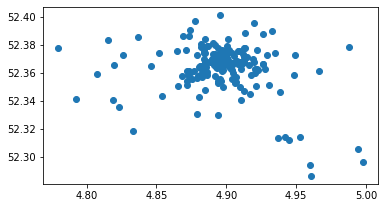

In [15]:
### COMBINE BAG & GOOGLE+TRIPADVISOR+WIKIPEDIA DATA ###

# import datasets and convert dtypes
bag = pd.read_csv('data/bag-fgtw.csv', delimiter=',')
bag['geometry'] = gpd.GeoSeries.from_wkt(bag['geometry'], crs='epsg:32631')

# import datasets and convert dtypes
fgtw = pd.read_csv('data/fgtw-data.csv', delimiter=',')
fgtw['geometry'] = gpd.GeoSeries.from_wkt(fgtw['geometry'], crs='epsg:32631')

# plot data
fgtwgeodata = gpd.GeoDataFrame(geometry=fgtw['geometry'])
fgtwgeodata.plot()

# normalize values and group pageviews
fgtw['g_results'] = fgtw['g_results'] / fgtw['g_results'].max()
fgtw['g_reviews'] = fgtw['g_reviews'] / fgtw['g_reviews'].max()
fgtw['t_reviews'] = fgtw['t_reviews'] / fgtw['t_reviews'].max()
fgtw['w_edits'] = fgtw['w_edits'] / fgtw['w_edits'].max()
fgtw['w_languages'] = fgtw['w_languages'] / fgtw['w_languages'].max()
fgtw['w_views_nl'] = fgtw['w_views_nl'] / fgtw['w_views_nl'].max()
fgtw['w_views_en'] = fgtw['w_views_en'] / fgtw['w_views_en'].max()
fgtw['w_views'] = (fgtw['w_views_nl'] + fgtw['w_views_en']) / 2
fgtw['w_views'] = fgtw['w_views'] / fgtw['w_views'].max()

# calculate Google/GoogleMaps/TripAdvisor/WikiPedia in 200 meter radius of every address in BAG
bag['g_results'] = 0.0
bag['g_reviews'] = 0.0
bag['g_rating'] = 0.0
bag['g_score'] = 0.0
bag['t_reviews'] = 0.0
bag['t_rating'] = 0.0
bag['t_score'] = 0.0
bag['w_views'] = 0.0
bag['w_edits'] = 0.0
bag['w_languages'] = 0.0
bag['w_score'] = 0.0
bag['rating_count'] = 0
for row in tqdm(bag['index']) :
    point1 = bag['geometry'][row]
    ratingcount = 0
    googleresults = 0.0
    googlemapsreviews = 0.0
    googlemapsrating = 0.0
    tripadvisorreviews = 0.0
    tripadvisorrating = 0.0
    wikipediaviews = 0.0
    wikipediaedits = 0.0
    wikipedialanguages = 0.0
    for num in fgtw['index'] :
        point2 = fgtw['geometry'][num]
        if distance(point1, point2) < 200 :
            ratingcount += 1
            googleresults += fgtw['g_results'][num]
            googlemapsreviews += fgtw['g_reviews'][num]
            googlemapsrating += fgtw['g_rating'][num]
            tripadvisorreviews += fgtw['t_reviews'][num]
            tripadvisorrating += fgtw['t_rating'][num]
            wikipediaviews += fgtw['w_views'][num]
            wikipediaedits += fgtw['w_edits'][num]
            wikipedialanguages += fgtw['w_languages'][num]
    if ratingcount == 0 :
        ratingcount = 1
    bag['rating_count'][row] = ratingcount
    bag['g_results'][row] = googleresults
    bag['g_reviews'][row] = googlemapsreviews
    bag['g_rating'][row] = googlemapsrating
    bag['t_reviews'][row] = tripadvisorreviews
    bag['t_rating'][row] = tripadvisorrating
    bag['w_views'][row] = wikipediaviews
    bag['w_edits'][row] = wikipediaedits
    bag['w_languages'][row] = wikipedialanguages
# recalculate total rating to average rating
bag['g_rating'] = bag['g_rating'] / bag['rating_count']
bag['t_rating'] = bag['t_rating'] / bag['rating_count']    
# normalize results
bag['g_results'] = bag['g_results'] / bag['g_results'].max()
bag['g_reviews'] = bag['g_reviews'] / bag['g_reviews'].max()
bag['g_rating'] = bag['g_rating'] / bag['g_rating'].max()
bag['t_reviews'] = bag['t_reviews'] / bag['t_reviews'].max()
bag['t_rating'] = bag['t_rating'] / bag['t_rating'].max()
bag['w_views'] = bag['w_views'] / bag['w_views'].max()
bag['w_edits'] = bag['w_edits'] / bag['w_edits'].max()
bag['w_languages'] = bag['w_languages'] / bag['w_languages'].max()
# calculate and normalize average score of each individual source
bag['g_score'] = (bag['g_results'] + bag['g_reviews'] + bag['g_rating']) / 3
bag['g_score'] = bag['g_score'] / bag['g_score'].max()
bag['t_score'] = (bag['t_reviews'] + bag['t_rating']) / 2
bag['t_score'] = bag['t_score'] / bag['t_score'].max()
bag['w_score'] = (bag['w_views'] + bag['w_edits'] + bag['w_languages']) / 3
bag['w_score'] = bag['w_score'] / bag['w_score'].max()
# calculate score of flickr & google+tripadvisor+wikipedia in equal share and normalize
bag['score'] = ((3 * bag['f_score']) + (bag['g_score'] + bag['t_score'] + bag['w_score'])) / 6
bag['score'] = bag['score'] / bag['score'].max()

# drop count column and save dataset
bag.drop(columns=['rating_count'], inplace=True)                
bag.to_csv('data/bag-fgtw.csv', index = False)

# save only entries with a score higher than 0
bagscore = bag[bag['score'] > 0]
bagscore.to_csv('data/bag-fgtw-score.csv', index = False)

In [ ]:
### CALCULATE CORRELATION ###

fgtw.corr()

In [ ]:
### DISPLAY POINTS & HEAT ON MAP ###

# import and convert all the scored BAG addresses
fgtw = pd.read_csv('data/bag-fgtw-score.csv', delimiter=',')
fgtw['geometry'] = gpd.GeoSeries.from_wkt(fgtw['geometry'], crs='epsg:32631')
fgtwgeodata = gpd.GeoDataFrame(geometry=fgtw['geometry'])
osm = pd.DataFrame(data = {'lon': fgtwgeodata['geometry'].x, 'lat': fgtwgeodata['geometry'].y})

# create the map of Amsterdam on OpenStreetMaps with specific zoom level
osmmap = folium.Map([52.357956, 4.897070], zoom_start=13)

# put points on the map
for index, row in osm.iterrows() :
  folium.CircleMarker([row['lat'], row['lon']], radius=1, color='#ff0000', weight=1, opacity=0.5, stroke=True).add_to(osmmap)

# create heatmap
osmarray = osm[['lat', 'lon']].values
osmmap.add_child(plugins.HeatMap(osmarray, radius=15))

# display map of all scored BAG addresses
osmmap